# UIUC Grid Demand: Wind Power + Solar Elevation Angle

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the Wind Power at the University of Illinois.
Rather than one input, there are two inputs: Wind Power and Solar Elevation Angle. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/railsplitter_data.csv", usecols=['Time','MWh'])
windpower = np.array(dataframe.MWh).astype('float64')

# normalize
norm = np.linalg.norm(windpower)
# norm = np.max(windpower)
windpower_norm = windpower/norm

In [3]:
lat = 40.18
lon = -89.24
time_range = pd.date_range(start='11/1/2016', end='7/1/2019', freq='h')[:len(windpower)]
elevation = generate_elevation_series(time_range, lat=lat, lon=lon, timestamps=True)
norm_a = np.linalg.norm(elevation)
# norm_a = np.max(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of wind power: {norm}")

Norm of elevation angles: 5528.904286307141
Norm of wind power: 608.6097404642815


## Format the Input Data

In [4]:
X_in = np.concatenate([[windpower_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 23328)


In [5]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':None, 
          'trainlen':8000}

In [6]:
futureTotal = params['future']
time_range = np.array(dataframe.Time)
hour_range = np.arange(0, len(time_range), 1)

## 1. Initial Demonstration


In [7]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 4.65 seconds
This simulation took 0.08 minutes


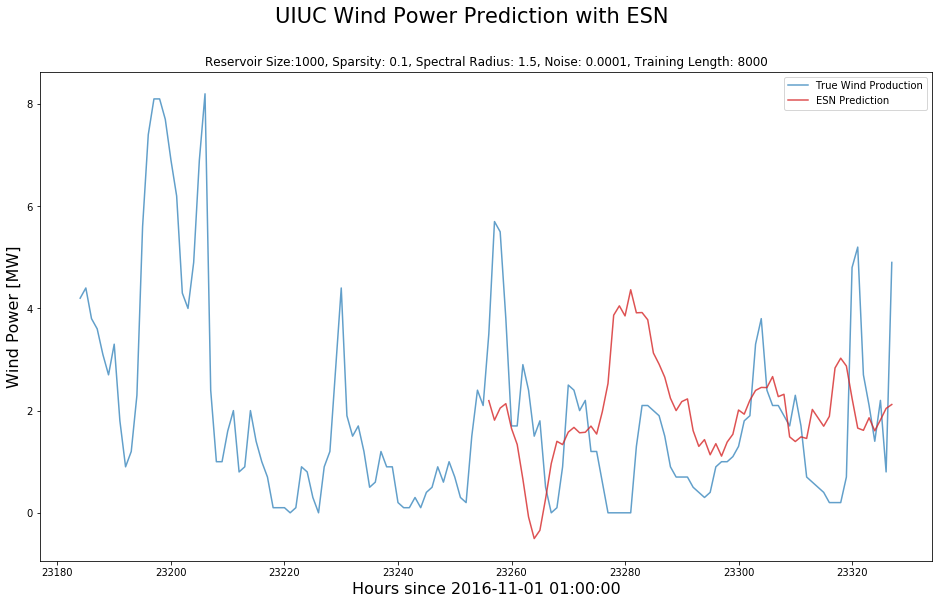

In [8]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.004834279118472812
rho = 0.5, noise = 0.0003, MSE=0.004816658758746725
rho = 0.5, noise = 0.0007, MSE=0.004735408633983301
rho = 0.5, noise = 0.001, MSE=0.004695100338410446
rho = 0.5, noise = 0.003, MSE=0.005015354210679404
rho = 0.5, noise = 0.005, MSE=0.005621102056656123
rho = 0.5, noise = 0.007, MSE=0.006041661328679573
rho = 0.5, noise = 0.01, MSE=0.006372124013966251
rho = 0.7, noise = 0.0001, MSE=0.003945339441160263
rho = 0.7, noise = 0.0003, MSE=0.004653991507557344
rho = 0.7, noise = 0.0007, MSE=0.004755985340102893
rho = 0.7, noise = 0.001, MSE=0.004860608500906676
rho = 0.7, noise = 0.003, MSE=0.005303890701875629
rho = 0.7, noise = 0.005, MSE=0.005832272135838928
rho = 0.7, noise = 0.007, MSE=0.006364298944941162
rho = 0.7, noise = 0.01, MSE=0.006879677642507779
rho = 0.9, noise = 0.0001, MSE=0.002473753933813759
rho = 0.9, noise = 0.0003, MSE=0.0029891554522977993
rho = 0.9, noise = 0.0007, MSE=0.00391450

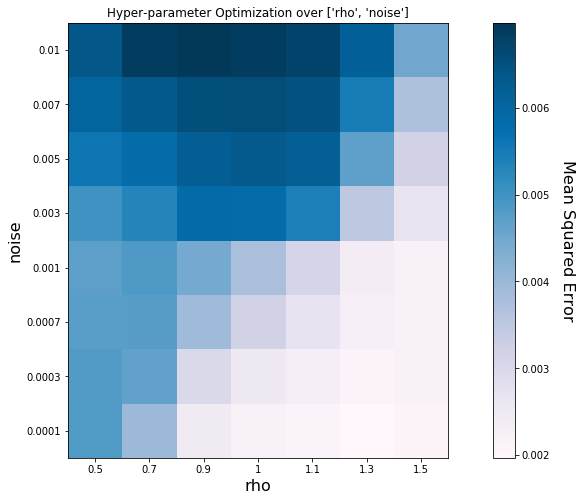

In [9]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [10]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.3 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0017524172468122014
n_reservoir = 600, sparsity = 0.01, MSE=0.0018725087951876572
n_reservoir = 600, sparsity = 0.03, MSE=0.0016043757470558108
n_reservoir = 600, sparsity = 0.05, MSE=0.0016115263372210164
n_reservoir = 600, sparsity = 0.1, MSE=0.0016673614869050979
n_reservoir = 600, sparsity = 0.15, MSE=0.002108799135806479
n_reservoir = 600, sparsity = 0.2, MSE=0.0019276008800703788
n_reservoir = 800, sparsity = 0.005, MSE=0.002183391032078374
n_reservoir = 800, sparsity = 0.01, MSE=0.002254685881693895
n_reservoir = 800, sparsity = 0.03, MSE=0.002064899179418575
n_reservoir = 800, sparsity = 0.05, MSE=0.0020506635460164502
n_reservoir = 800, sparsity = 0.1, MSE=0.0019842290318966994
n_reservoir = 800, sparsity = 0.15, MSE=0.0020804393375535193
n_reservoir = 800, sparsity = 0.2, MSE=0.0019193502074480986
n_reservoir = 1000, sparsity = 0.005, MSE=0.002219212925530875
n_reservoir = 1000, sparsity =

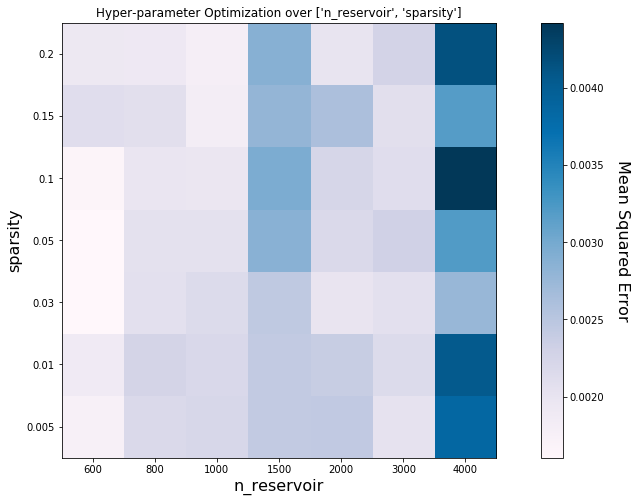

In [11]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [12]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 600 
sparsity = 0.03


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.0031353220418107093
trainlen = 5300, MSE=0.002775958574490853
trainlen = 5600, MSE=0.00290158056520679
trainlen = 5900, MSE=0.002081298285705845
trainlen = 6200, MSE=0.00199640631627444
trainlen = 6500, MSE=0.002214577241859902
trainlen = 6800, MSE=0.002322321227030768
trainlen = 7100, MSE=0.0027481036511936034
trainlen = 7400, MSE=0.0021052711974995676
trainlen = 7700, MSE=0.0018133286359910022
trainlen = 8000, MSE=0.0016043757470558108
trainlen = 8300, MSE=0.002453694253699104
trainlen = 8600, MSE=0.00199868736016431
trainlen = 8900, MSE=0.0024025294062919858
trainlen = 9200, MSE=0.002188046914788355
trainlen = 9500, MSE=0.0017010957595219578
trainlen = 9800, MSE=0.0017308200290061945
trainlen = 10100, MSE=0.0019119355664459446
trainlen = 10400, MSE=0.001971310808970254
trainlen = 10700, MSE=0.0018604944183913744
trainlen = 11000, MSE=0.0018493258151017688
trainlen = 11300, MSE=0.0019412651019111002
trainlen = 11600, MSE=0.00173579

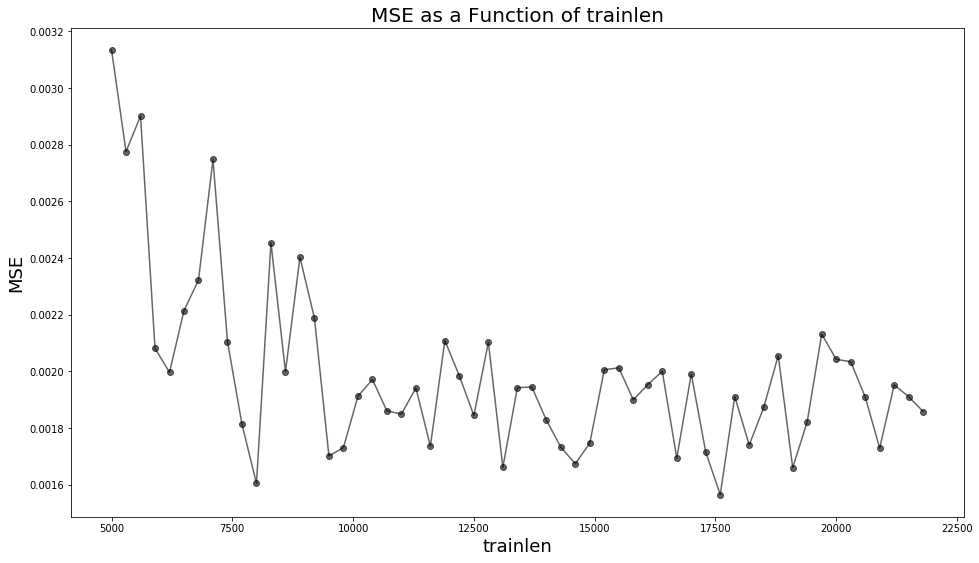

In [13]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,22000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [14]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 17600


### 5. Optimized Demand Prediction


In [15]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 2.16 seconds
This simulation took 0.04 minutes


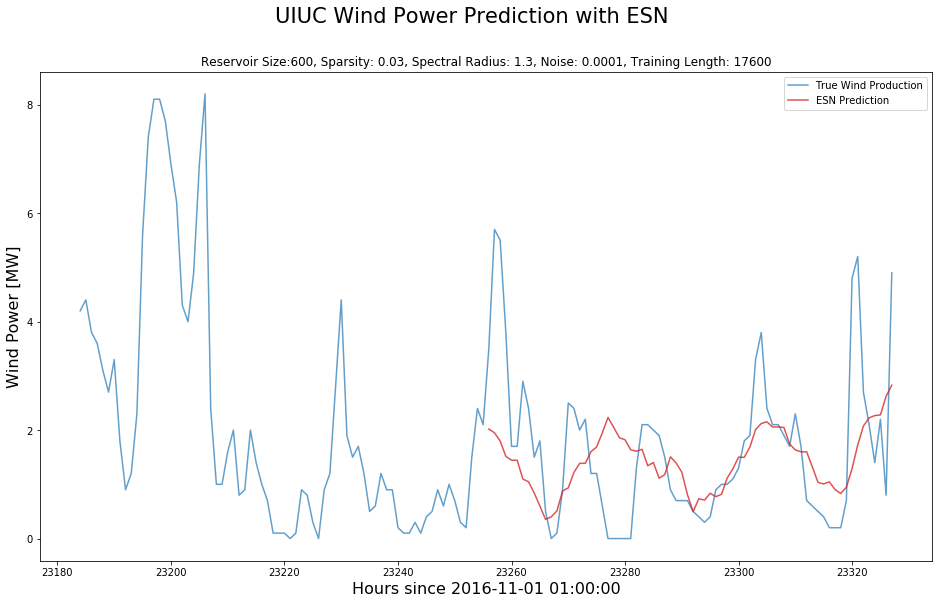

In [16]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### Check other reservoir sizes for fun

In [17]:
nonopt_params = {'n_reservoir':2000, 
          'sparsity':0.03, 
          'rand_seed':85, 
          'rho':opt_radius, 
          'noise':opt_noise, 
          'future':72, 
          'window':None, 
          'trainlen':l_opt}

In [18]:
tic = time.perf_counter()

nonopt_pred = esn_prediction(X_in.T, nonopt_params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 41.96 seconds
This simulation took 0.70 minutes


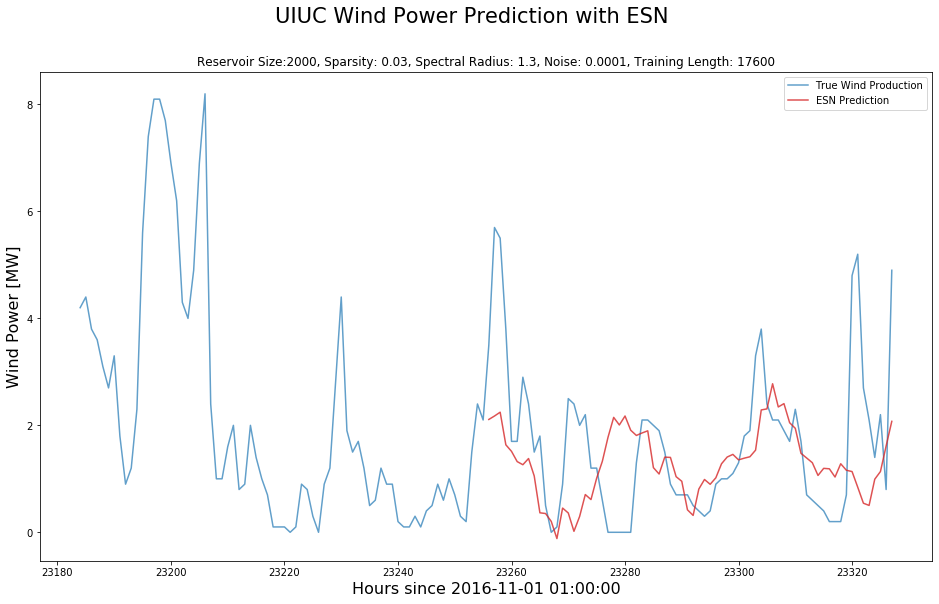

In [19]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(nonopt_params))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*nonopt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [20]:
nonopt_params_v2 = {'n_reservoir':1000, 
          'sparsity':0.2, 
          'rand_seed':85, 
          'rho':opt_radius, 
          'noise':opt_noise, 
          'future':72, 
          'window':None, 
          'trainlen':l_opt}

In [21]:
tic = time.perf_counter()

nonopt_pred_v2 = esn_prediction(X_in.T, nonopt_params_v2)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 6.29 seconds
This simulation took 0.10 minutes


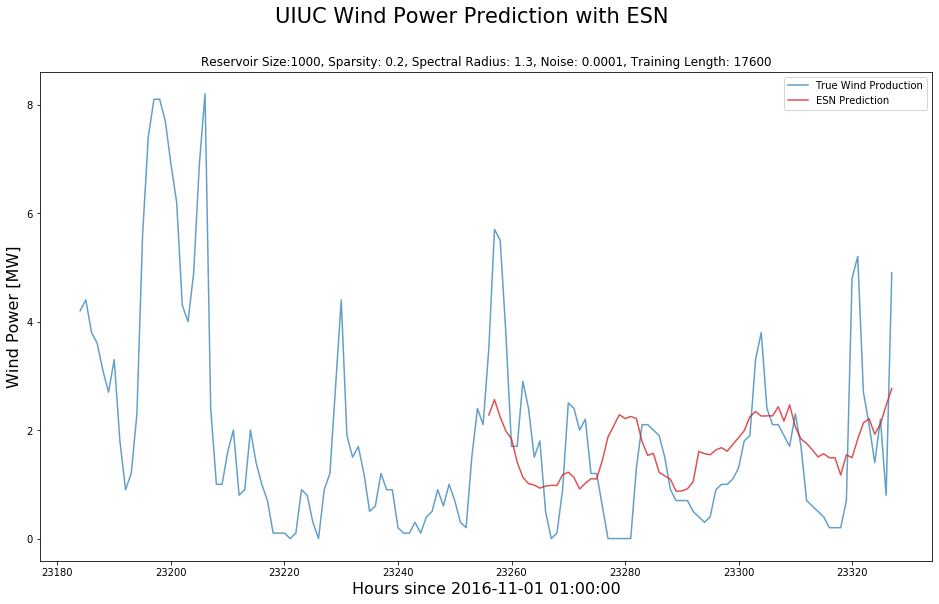

In [22]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(nonopt_params_v2))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*nonopt_pred_v2.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [23]:
nonopt_params_v3 = {'n_reservoir':8000, 
          'sparsity':0.2, 
          'rand_seed':85, 
          'rho':opt_radius, 
          'noise':opt_noise, 
          'future':72, 
          'window':None, 
          'trainlen':l_opt}

In [24]:
tic = time.perf_counter()

nonopt_pred_v3 = esn_prediction(X_in.T, nonopt_params_v3)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 850.67 seconds
This simulation took 14.18 minutes


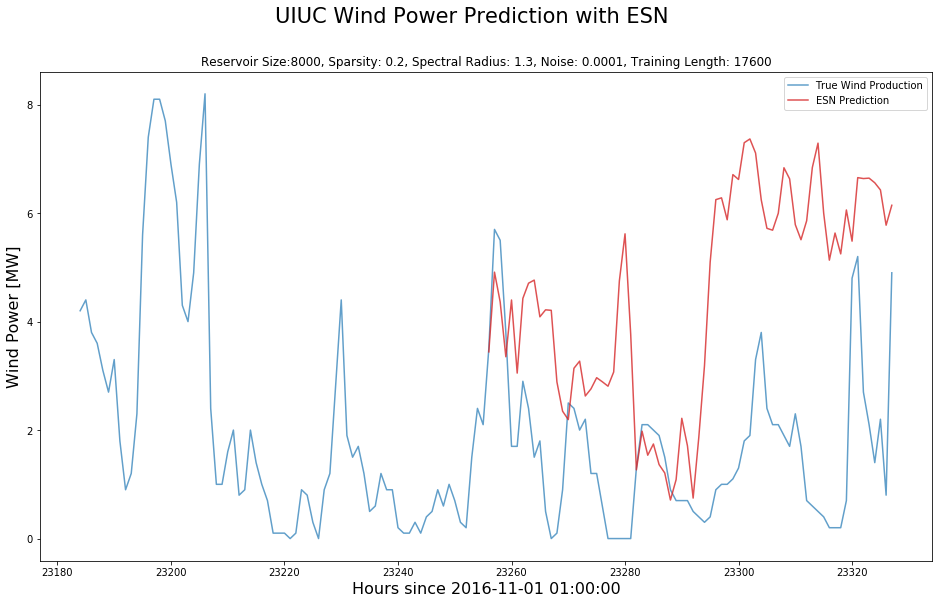

In [25]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(nonopt_params_v3))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*nonopt_pred_v3.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [26]:
nonopt_params_v4 = {'n_reservoir':4000, 
          'sparsity':0.05, 
          'rand_seed':85, 
          'rho':opt_radius, 
          'noise':opt_noise, 
          'future':72, 
          'window':None, 
          'trainlen':l_opt}

In [27]:
tic = time.perf_counter()

nonopt_pred_v4 = esn_prediction(X_in.T, nonopt_params_v4)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 177.80 seconds
This simulation took 2.96 minutes


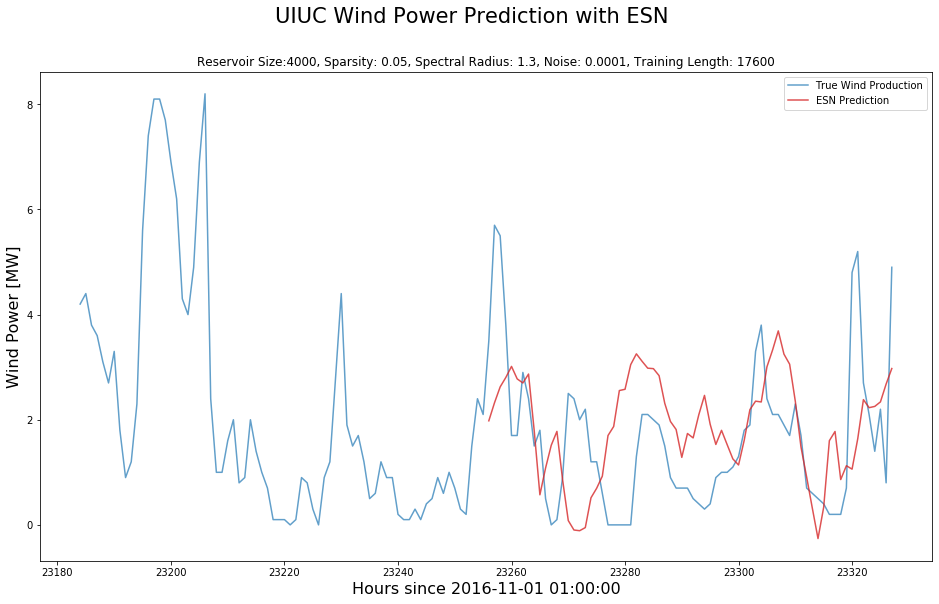

In [28]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Power Prediction with ESN", fontsize=21)
plt.title(param_string(nonopt_params_v4))
plt.ylabel("Wind Power [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*nonopt_pred_v4.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 6. Uncertainty Calculation

In [13]:
params = {'n_reservoir':600, 
          'sparsity':0.03, 
          'rand_seed':85, 
          'rho':1.3, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':17600}

rand_seeds = [85, 21, 22, 30, 122, 5, 79]

In [14]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 14.19 seconds
This simulation took 0.24 minutes


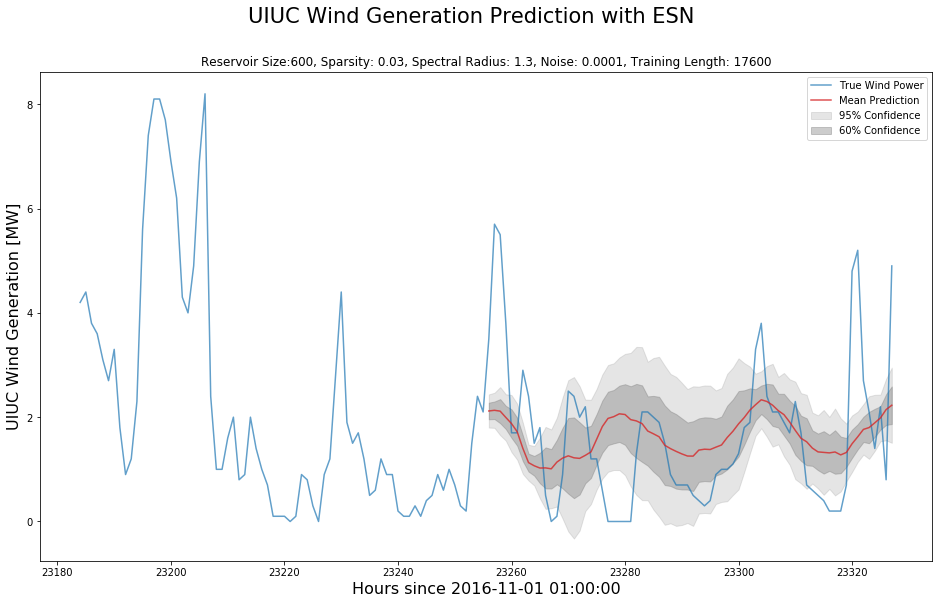

In [15]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Wind Generation [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='Mean Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

### 7. Shorter Window Length

In [10]:
params['window'] = 1

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 2156.38 seconds
This simulation took 35.94 minutes


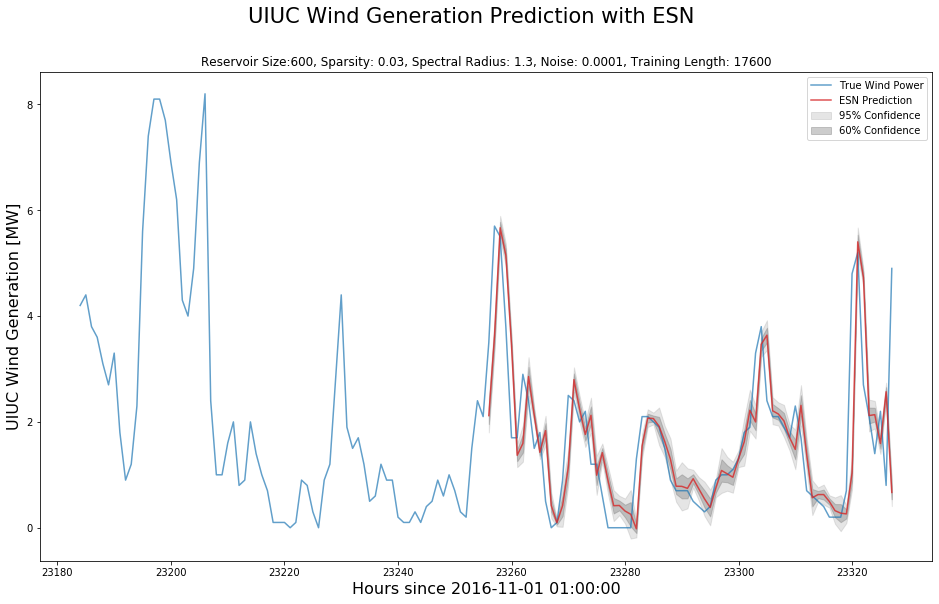

In [11]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Wind Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Wind Generation [MW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*windpower_norm[-2*futureTotal:],'b',label="True Wind Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()